# Importation des bibliothèques

In [1]:
# personnal libraries
from DataGenerator import DataGenerator
from functions import *

# display libraries
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Keras
import keras
from keras import layers
from keras import models

# classification libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# useful libraries
import numpy as np
import pandas as pd
import random
import sys
import cv2

from google.colab import drive

# Importation des images

On importe les images se situant dans le Drive.

In [2]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
local_drive = '/content/drive/MyDrive/'

sys.path.append(local_drive)
%cd $local_drive

# %ls

/content/drive/MyDrive


# Génération des données

À l'aide de la fonction *getImages()* on crée les listes des chemins vers chaque images de notre jeu de données.

In [4]:
train_paths = getImages(directory='annotated_pics')
validation_paths = getImages(directory='annotated_pics')
test_paths = getImages(directory='annotated_pics')

In [5]:
batch_size = 500
img_width, img_height = 24, 24

train_generator = DataGenerator(data_frame=train_paths, batch_size=batch_size, num_classes=2)
validation_generator = DataGenerator(data_frame=validation_paths, batch_size=batch_size, num_classes=2)
test_generator = DataGenerator(data_frame=test_paths, batch_size=batch_size, num_classes=2)

In [6]:
num_train_batches = len(train_generator)
num_validation_batches = len(validation_generator)
num_test_batches = len(test_generator)

print(f"[Info] - nombre de batch d'apprentissage: {num_train_batches}")
print(f"[Info] - nombre de batch de validation: {num_validation_batches}")
print(f"[Info] - nombre de batch de test: {num_test_batches}")

[Info] - nombre de batch d'apprentissage: 5
[Info] - nombre de batch de validation: 5
[Info] - nombre de batch de test: 5


In [7]:
train_images, train_labels = train_generator.__getitem__(random.randint(0, num_train_batches-1))
print("[Debug] - jeu d'apprentissage créé")
validation_images, validation_labels = validation_generator.__getitem__(random.randint(0, num_validation_batches-1))
print("[Debug] - jeu de validation créé")
test_images, test_labels = test_generator.__getitem__(random.randint(0, num_test_batches-1))
print("[Debug] - jeu de test créé")

[Debug] - jeu d'apprentissage créé
[Debug] - jeu de validation créé
[Debug] - jeu de test créé


In [8]:
print("Nombre d'exemples du jeu d'apprentissage: ", train_images.shape[0])
print("Format du jeu d'apprentissage: ", train_images.shape)
print("Format des labels pour le jeu d'apprentissage: ", train_labels.shape, '\n')
print("Nombre d'exemples du jeu de test: ", test_images.shape[0])

Nombre d'exemples du jeu d'apprentissage:  500
Format du jeu d'apprentissage:  (500, 24, 24)
Format des labels pour le jeu d'apprentissage:  (500,) 

Nombre d'exemples du jeu de test:  500


# Augmentation des données

In [9]:
augmented_train_images, augmented_train_lables = augment(train_images, train_labels)
print("[Info] - augmentation des données réussie")

[Info] - augmentation des données réussie


In [10]:
train_images, train_labels = np.concatenate((train_images, augmented_train_images)), np.concatenate((train_labels, train_labels))

# Un modèle traditionnel
Dans cette section, nous utilisons un classifier "traditionnel". En fait, il s'agit ici de créer un modèle baseline afin de pouvoir avoir une
comparaison.
Pour rappel, comme l'image est une matrice, il est d'abord nécessaire de "l'applatir" afin de la transformer en vecteur. Par la suite comme il y a beaucoup de features, nous utiliserons une PCA pour réduire le nombre de dimensions. Enfin nous utilisons un simple modèle Naïve Bayes.

De manière à ne pas être biaisé par la répartition des données, il est important de faire une cross
validation.

In [11]:
seed = 7
nb_splits = 30
k_fold = KFold(n_splits=nb_splits, shuffle=True, random_state=seed)

# transformation des données d'entrainement en vecteur
temp_tab = []
for i in range(0, len(train_images)):
    temp_tab.append(train_images[i].flatten())
train_images_reshaped = np.array(temp_tab)

In [12]:
print("[Info] - shape after flattening each image matrix:", train_images_reshaped.shape)
print(train_images_reshaped)

[Info] - shape after flattening each image matrix: (1000, 576)
[[123 127 115 ... 124 127 124]
 [155 161 164 ... 180 198 212]
 [156 166 152 ... 117 115 113]
 ...
 [161 190 174 ... 172 165 149]
 [139 141 144 ... 127 134 142]
 [ 96  99 102 ... 169 160 150]]


In [13]:
print("[Info] - vecteur des labels du jeu d'apprentissage (0 pour abeilles & 1 pour alvéole)")
print(train_labels)

[Info] - vecteur des labels du jeu d'apprentissage (0 pour abeilles & 1 pour alvéole)
[1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0
 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 0 1 1 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1 0
 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0
 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0
 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0
 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 1
 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1
 0 0 0 0 0 0 0

In [14]:
pipe = Pipeline([
  ('pca', PCA(n_components=90)),
  ('clf', GaussianNB())
])

In [15]:
print(f"Evaluation de {pipe['clf']} sur {nb_splits} splits")
score = cross_val_score(pipe, train_images_reshaped, train_labels,cv=k_fold, scoring='accuracy')
print(f'Les différentes accuracy pour les {nb_splits} évaluations sont : \n', score,'\n')
print ('Accuracy moyenne : %0.3f'%(score.mean()),' standard deviation %0.3f'%(score.std()))

Evaluation de GaussianNB() sur 30 splits
Les différentes accuracy pour les 30 évaluations sont : 
 [0.82352941 0.79411765 0.79411765 0.85294118 0.85294118 0.82352941
 0.88235294 0.82352941 0.82352941 0.91176471 0.93939394 0.90909091
 0.96969697 0.75757576 0.90909091 0.90909091 0.84848485 0.81818182
 0.72727273 0.72727273 0.81818182 0.87878788 0.87878788 0.6969697
 0.87878788 0.72727273 0.90909091 0.81818182 0.75757576 0.93939394] 

Accuracy moyenne : 0.840  standard deviation 0.070


# Un modèle simple de raiseau de neurones

In [16]:
model = models.Sequential([
  layers.Flatten(input_shape=(24, 24)),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(2, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 128)               73856     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 82,242
Trainable params: 82,242
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
temp_tab = []
for i in range(len(test_images)):
    temp_tab.append(test_images[i].flatten())
test_images_reshaped = np.array(temp_tab)

In [19]:
# attention ne pas oublier de faire un pipe.fit pour créer le modèle final
pipe.fit(train_images_reshaped, train_labels)
# transformation des données de test en vecteur au lieu de matrice
y_predicted = pipe.predict(test_images_reshaped)
print("Accuracy sur le jeu de test:", accuracy_score(test_labels.reshape(-1), y_predicted.ravel()))

Accuracy sur le jeu de test: 0.858


## Prédiction sur les données de test

In [20]:
temp_tab = []
for i in range(0, len(validation_images)):
    temp_tab.append(validation_images[i].flatten())
validation_images_reshaped = np.array(temp_tab)

In [21]:
epochs = 10
history = model.fit(
    train_images,
    train_labels,
    validation_data=(validation_images, validation_labels),
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)

Epoch 1/10
5/5 [==============================] - 3s 60ms/step - loss: 74.9574 - accuracy: 0.5190 - val_loss: 45.0329 - val_accuracy: 0.5940
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 27.4230 - accuracy: 0.4900 - val_loss: 37.5783 - val_accuracy: 0.5940
Epoch 3/10
5/5 [==============================] - 0s 12ms/step - loss: 22.9293 - accuracy: 0.5080 - val_loss: 9.9689 - val_accuracy: 0.4460
Epoch 4/10
5/5 [==============================] - 0s 12ms/step - loss: 13.8065 - accuracy: 0.5530 - val_loss: 16.4410 - val_accuracy: 0.4100
Epoch 5/10
5/5 [==============================] - 0s 11ms/step - loss: 14.0839 - accuracy: 0.5010 - val_loss: 15.1095 - val_accuracy: 0.5900
Epoch 6/10
5/5 [==============================] - 0s 11ms/step - loss: 10.1479 - accuracy: 0.4830 - val_loss: 10.5425 - val_accuracy: 0.5880
Epoch 7/10
5/5 [==============================] - 0s 14ms/step - loss: 9.3940 - accuracy: 0.4990 - val_loss: 4.6061 - val_accuracy: 0.4900
Epoch 8/10
5/5 [

In [22]:
scores = model.evaluate(test_images, test_labels, steps=len(test_generator))
print("Accuracy sur le jeu de test %0.2f"%(scores[1] * 100), "%")

5/5 [==============================] - 0s 4ms/step - loss: 8.4817 - accuracy: 0.4540
Accuracy sur le jeu de test 45.40 %


In [23]:
predict_y = model.predict(test_images)
y_pred = np.argmax(predict_y,axis=1)

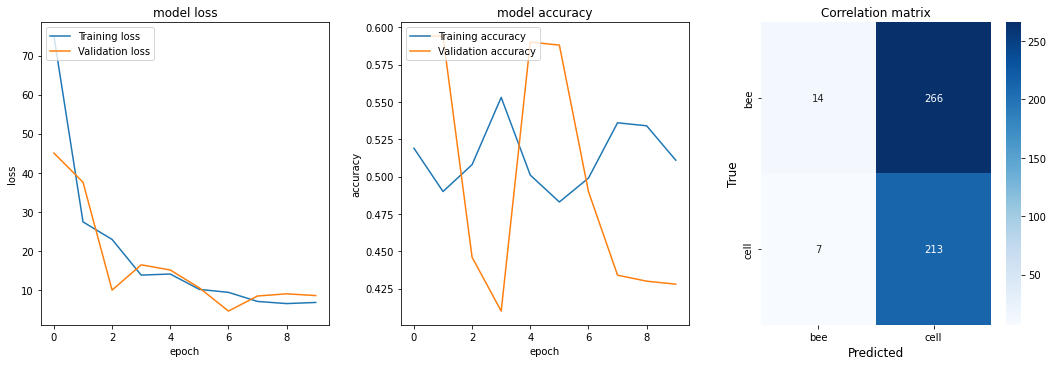

In [24]:
conf = confusion_matrix(test_labels, y_pred)

plot_curves_confusion(history, conf, ['bee', 'cell'])

# Un modèle plus compliqué: modèle à convolution (CNN)
Dans cette section nous utilisons un modèle de CNN particulièrement adapté aux images.

In [25]:
model = models.Sequential([
  layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(24, 24, 1), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.3),
  layers.Flatten(),
  #layers.Dense(128, activation='relu'),
  #layers.Dense(64, activation='relu'),
  #layers.Dense(32, activation='relu'),
  layers.Dense(2, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 22, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 4, 4, 32)          0         
                                                                 
 flatten_1 (Flatten)         (None, 512)              

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [27]:
epochs = 10
history = model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)

Epoch 1/10
5/5 [==============================] - 8s 70ms/step - loss: 13.4733 - accuracy: 0.5340 - val_loss: 3.3392 - val_accuracy: 0.4640
Epoch 2/10
5/5 [==============================] - 0s 18ms/step - loss: 7.6180 - accuracy: 0.4760 - val_loss: 4.6858 - val_accuracy: 0.5560
Epoch 3/10
5/5 [==============================] - 0s 19ms/step - loss: 4.2404 - accuracy: 0.5140 - val_loss: 2.0895 - val_accuracy: 0.4480
Epoch 4/10
5/5 [==============================] - 0s 21ms/step - loss: 2.0331 - accuracy: 0.5350 - val_loss: 0.8312 - val_accuracy: 0.5760
Epoch 5/10
5/5 [==============================] - 0s 18ms/step - loss: 0.9868 - accuracy: 0.5260 - val_loss: 0.7096 - val_accuracy: 0.5560
Epoch 6/10
5/5 [==============================] - 0s 20ms/step - loss: 0.7031 - accuracy: 0.5870 - val_loss: 0.6895 - val_accuracy: 0.5620
Epoch 7/10
5/5 [==============================] - 0s 20ms/step - loss: 0.6914 - accuracy: 0.5860 - val_loss: 0.6880 - val_accuracy: 0.5660
Epoch 8/10
5/5 [==========

In [28]:
scores = model.evaluate(test_images, test_labels, steps=len(test_generator))
print("Accuracy sur le jeu de test %0.2f"%(scores[1] * 100), "%")

5/5 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5600
Accuracy sur le jeu de test 56.00 %


In [29]:
predict_y = model.predict(test_images)
y_pred = np.argmax(predict_y,axis=1)

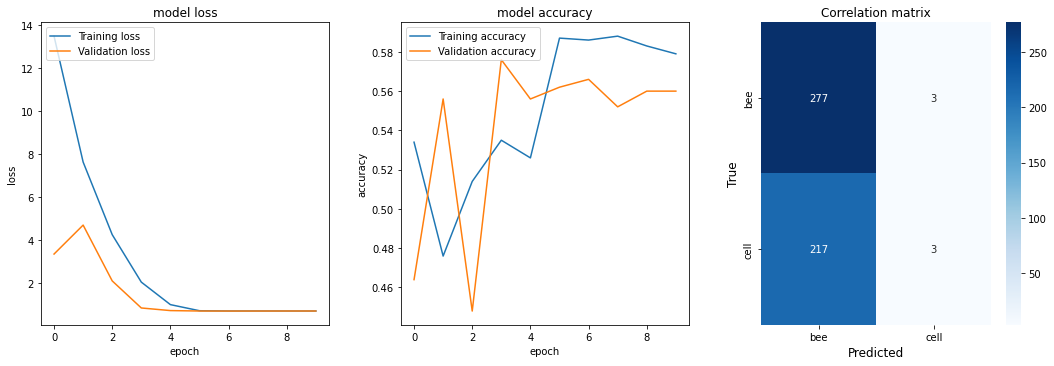

In [30]:
conf = confusion_matrix(test_labels, y_pred)

plot_curves_confusion(history, conf, ['bee', 'cell'])

In [31]:
inputs = np.concatenate((train_images, test_images), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)

nb_folds = 2
acc_per_fold = []
loss_per_fold = []

kfold = KFold(n_splits=nb_folds, shuffle=True)

In [32]:
fold_no = 1
for train, test in kfold.split(inputs, targets):
  model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(24, 24, 1), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='sigmoid')
  ])
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

  print(f'[Info] - Entrainement pour le fold {fold_no}')
  history = model.fit(
    inputs[train],
    targets[train],
    epochs=epochs,
    steps_per_epoch=len(train_generator) + len(test_generator),
    validation_steps=len(validation_generator)
  )
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score pour fold {fold_no}: {model.metrics_names[0]}={scores[0]} - {model.metrics_names[1]}={scores[1] * 100}%\n')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  fold_no += 1

[Info] - Entrainement pour le fold 1
Epoch 1/10
10/10 [==============================] - 1s 6ms/step - loss: 3.4260 - accuracy: 0.5027
Epoch 2/10
10/10 [==============================] - 0s 6ms/step - loss: 0.8250 - accuracy: 0.5147
Epoch 3/10
10/10 [==============================] - 0s 6ms/step - loss: 0.7488 - accuracy: 0.5520
Epoch 4/10
10/10 [==============================] - 0s 5ms/step - loss: 0.7239 - accuracy: 0.5760
Epoch 5/10
10/10 [==============================] - 0s 7ms/step - loss: 0.7234 - accuracy: 0.5333
Epoch 6/10
10/10 [==============================] - 0s 6ms/step - loss: 0.6759 - accuracy: 0.5813
Epoch 7/10
10/10 [==============================] - 0s 6ms/step - loss: 0.6525 - accuracy: 0.6213
Epoch 8/10
10/10 [==============================] - 0s 6ms/step - loss: 0.6424 - accuracy: 0.6107
Epoch 9/10
10/10 [==============================] - 0s 6ms/step - loss: 0.6867 - accuracy: 0.5640
Epoch 10/10
10/10 [==============================] - 0s 6ms/step - loss: 0.6572 -

In [33]:
print('Scores par fold :')
for i in range(0, len(acc_per_fold)):
  print(f"\tFold {i + 1} Accuracy: {acc_per_fold[i]} % - Loss {loss_per_fold[i]}")

print('\nScores moyens pour tous les folds:')
print(f'\tAccuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'\tLoss: {np.mean(loss_per_fold)}')

Scores par fold :
	Fold 1 Accuracy: 65.86666703224182 % - Loss 0.6364474892616272
	Fold 2 Accuracy: 71.8666672706604 % - Loss 0.6049096584320068

Scores moyens pour tous les folds:
	Accuracy: 68.86666715145111 (+- 3.0000001192092896)
	Loss: 0.620678573846817


In [34]:
# prédiction avec le modèle chargé
nb_images = 100
images = []
labels = []
for i in range(0, nb_images):
  k = random.randint(0, len(test_images) - 1)
  images.append(test_images[k])
  labels.append(test_labels[k])

images = np.array(images)
labels = np.array(labels)
predict_y = model.predict(images)
y_pred = np.argmax(predict_y, axis=1)
y_pred.astype('int')

m = 0
for i in range(0, len(y_pred)):
  # print("Classe réelle ", labels[i], "prédite", int(y_pred[i]))
  if int(y_pred[i]) == labels[i]:
    m += 1

print(f"[Info] - Nombre de classes bien prédites: {m}/{len(y_pred)}")

[Info] - Nombre de classes bien prédites: 67/100


# Recherche d'un classifieur efficace

In [35]:
classifiers = {
  'KNeighborsClassifier': KNeighborsClassifier(),
  'DecisionTreeClassifier': DecisionTreeClassifier(),
  'SVC': SVC()
}

params = {
  'KNeighborsClassifier' : [{'n_neighbors': list(range(1,15))}, {'metric': ['minkowski', 'euclidean', 'manhattan']}],
  'DecisionTreeClassifier': [{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}, {'criterion': ['gini', 'entropy']}, {'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}],
  'SVC':[{'C': [0.001, 0.01, 0.1, 1, 10], 'gamma' : [0.001, 0.01, 0.1, 1], 'kernel': ['linear','rbf']}]
}

In [36]:
class Result_Parameters:
  
  def __init__(self,name, score, parameters):
    self.name = name
    self.score = score
    self.parameters = parameters
  
  def __repr__(self):
    return repr((self.name, self.score, self.parameters))

In [37]:
results = []
for key,value in classifiers.items():
  gd_sr = GridSearchCV(estimator=value, param_grid=params[key], scoring='accuracy', cv=5, n_jobs=1)
  gd_sr.fit(train_images_reshaped, train_labels)
  result = Result_Parameters(key, gd_sr.best_score_, gd_sr.best_estimator_)
  results.append(result)

results = sorted(results, key=lambda result: result.score, reverse=True)

In [38]:
print('Le meilleur resultat:')
print('\tClassifier:', results[0].name, 'score %0.3f'%results[0].score, 'avec', results[0].parameters)
print('Tous les résultats:')
for result in results:
  print('\tClassifier:', result.name, 'score %0.3f'%result.score, 'avec', result.parameters)

Le meilleur resultat:
	Classifier: KNeighborsClassifier score 0.897 avec KNeighborsClassifier(n_neighbors=1)
Tous les résultats:
	Classifier: KNeighborsClassifier score 0.897 avec KNeighborsClassifier(n_neighbors=1)
	Classifier: DecisionTreeClassifier score 0.856 avec DecisionTreeClassifier(criterion='entropy')
	Classifier: SVC score 0.791 avec SVC(C=0.01, gamma=0.001, kernel='linear')


## Prédictions avec le classifieur le plus efficace

In [39]:
gd_sr = results[0].parameters
gd_sr.fit(train_images_reshaped, train_labels)

test_predicted = gd_sr.predict(test_images_reshaped)

In [40]:
n = 0
for i in range(len(test_predicted)):
  if test_labels[i] == test_predicted[i]:
    n += 1

print(f"[Info] - successfully predicted: {n}/{len(test_predicted)}")

[Info] - successfully predicted: 451/500


# Creation d'une fake image à partir d'une image de la vidéo
Il s'agit de prélever des images de taille proportionnelle à la taille des images d'apprentissage utilisées (24x24) depuis la vidéo et utilisé le classifieur le plus efficace sur celles-ci. Ensuite, nous créont une matrice de taille $\frac{L}{24} \times \frac{l}{24}$ et nous utilisons le classifieur pour prédire la classe ("abbeille" ou "alvéole") de chacune des sous-matrice de taille $24 \times 24$ de l'image appartennant à la vidéo. On crée par la suite une représentation de l'image prélevée.

In [41]:
frames = []

vidcap = cv2.VideoCapture("./images/video_abeilles.avi")
print("Number of frames: ", int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT)))
success, image = vidcap.read()
count = 0
while success:
  count += 1
  image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  frames.append(image)
  success, image = vidcap.read()

frames = np.array(frames)

Number of frames:  517


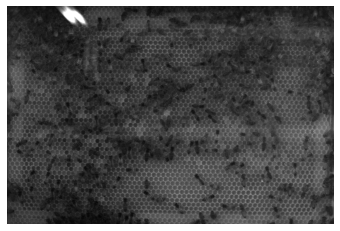

In [42]:
height, width = 768, 1152

img = frames[random.randint(0, count - 1)]
img = img[170:170+height, 550:550+width]

img = np.array(img)

# img.shape[0] => largeur = len(img1)
# img.shape[1] => longueur

plt.axis("off")
plt.imshow(img, cmap='gray')
plt.show()

In [43]:
img_reshaped = img.flatten()
#print(img_reshaped)

In [44]:
k = 1
zones = []

for i in range(0, height, 24):
  for j in range(0, width, 24):
    # Creation de la sous-image
    t = []
    for k in range(24):
      for l in range(24):
        index = (i + k) * width + j
        
        t.append(img_reshaped[index + l])
    zones.append(t)

# Classification de chaque sous-image
prediction = gd_sr.predict(zones)

In [45]:
fake_image = []

i = 0
while i < len(prediction):
  t = []
  for j in range(int(width / 24)):
    if prediction[i] == 1:
      t.append(2)
    else:
      t.append(0)
    i += 1
  fake_image.append(t)

np.set_printoptions(threshold=sys.maxsize)
fake_image = np.array(fake_image)

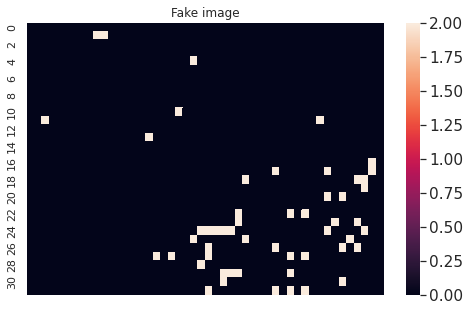


Noir: Abeille
Blanc: Alvéole


In [46]:
fm = pd.DataFrame(fake_image, columns=["" for i in range(fake_image.shape[1])])

sns.set(color_codes=True)
plt.figure(1, figsize=(8, 5))
plt.title("Fake image")

sns.set(font_scale=1.4)
ax = sns.heatmap(fm, fmt='g')

plt.show()
plt.close()

print("\nNoir: Abeille")
print("Blanc: Alvéole")

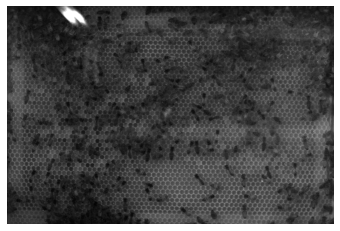

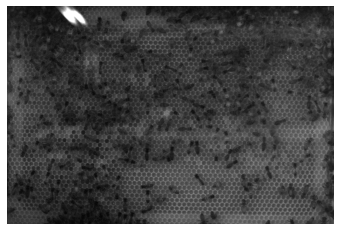

In [47]:
reshaped = []

for i in range(0,len(frames),30):
  img = frames[i]
  img = img[170:170+height, 550:550+width]
  img = np.array(img)
  reshaped.append(img)


imtest = reshaped[3]
imtest2 = reshaped[17]
plt.axis("off")
plt.imshow(imtest, cmap='gray')
plt.show()
plt.axis("off")
plt.imshow(imtest2, cmap='gray')
plt.show()

In [48]:
prediction = []

for a in range(len(reshaped)):
  pred = []
  zones = []
  img = reshaped[a]
  for i in range(0, height, 24):
    for j in range(0, width, 24):
      # Creation de la sous-image
      t = np.zeros((24, 24), dtype=int)
      for k in range(24):
        for l in range(24):
          t[k][l] = img[i + k][j + l]
      t = np.array(t)
      t = t.reshape(1, -1)
      zones.append(t)

  # Classification de chaque sous-image
  for m in range(len(zones)):
    pred.append(gd_sr.predict(zones[m].reshape(1,-1)))
  prediction.append(pred)

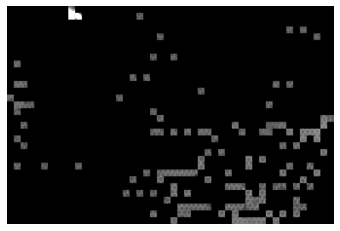

True

In [49]:
tab_alv = [0] * 1536 

img_result = np.zeros((height,width,3), np.uint8)
for i in range(len(prediction)):
  img_reshaped = reshaped[i]
  for j in range((len(prediction[i]))):
    img_alv = np.zeros((24,24),dtype=int)
    if prediction[i][j] == 1 and tab_alv[j] == 0 :
      y= int(j/48)
      x=(j-(48*y))*24
      y=(y)*24
      for k in range(24):
        m=y+k
        n=0
        for l in range(24):
          n=x+l
          img_result[m][n] = img_reshaped[m][n]
      tab_alv[j]=1

plt.axis("off")
plt.imshow(img_result)
plt.show()
cv2.imwrite('ImageAlvéole.png', img_result)

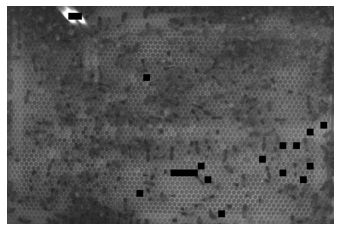

Nombre d'abeilles :  1517


In [50]:
tab_bee = [0] * 1536 
compteur = 0
img_result = np.zeros((height,width,3), np.uint8)
for i in range(len(prediction)):
  img_reshaped = reshaped[i]
  for j in range((len(prediction[i]))):
    img_bee = np.zeros((24,24),dtype=int)
    if prediction[i][j] == 0 and tab_bee[j] == 0 :
      y= int(j/48)
      x=(j-(48*y))*24
      y=(y)*24
      for k in range(24):
        m=y+k
        n=0
        for l in range(24):
          n=x+l
          img_result[m][n] = img_reshaped[m][n]
      tab_bee[j]=1
      compteur += 1

plt.axis("off")
plt.imshow(img_result)
plt.show()
cv2.imwrite('ImageAbeille.png', img_result)
print("Nombre d'abeilles : ",compteur)